In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/LDS9_K273_BuiThiHuong_Cuoi_ky/'

/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/LDS9_K273_BuiThiHuong_Cuoi_ky


In [81]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import time
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.regression import LinearRegressionModel, RandomForestRegressionModel, GBTRegressionModel

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
sc =SparkContext()

In [6]:
spark = SparkSession(sc)

## Read data

In [7]:
start_time = time.time()

In [8]:
# # Use Spark to read in the file
# data = spark.read.format("com.crealytics.spark.excel")\
#               .option("useHeader", "true")\
#               .option("treatEmptyValuesAsNulls", "true")\
#               .option("inferSchema", "true")\
#               .option("addColorColumns", "False")\
#               .load('Data/CCPP/Folds5x2_pp.xlsx')

In [9]:
df = pd.read_excel('Data/CCPP/Folds5x2_pp.xlsx', sheet_name=None) # => dictionary of dataframe, each sheet is a datafame
df = pd.concat(df, axis=0) # => concate all dataframe into a big dataframe
data = spark.createDataFrame(df) # => convert to pyspark dataframe

In [10]:
# Print the Schema of the DataFrame
data.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)



In [11]:
# number of rows and columns
print((data.count(), len(data.columns)))

(47840, 5)


In [12]:
data.head(1)

[Row(AT=14.96, V=41.76, AP=1024.07, RH=73.17, PE=463.26)]

In [13]:
for item in data.head():
    print(item)

14.96
41.76
1024.07
73.17
463.26


In [14]:
# column names
data.columns

['AT', 'V', 'AP', 'RH', 'PE']

In [15]:
data.show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
+-----+-----+-------+-----+------+
only showing top 5 rows



## EDA

### Univariable Analysis

#### Continious variavles

In [16]:
# desciption
lst_cont = ['AT', 'V', 'AP', 'RH', 'PE']
data.select(lst_cont).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|                AT|                 V|                AP|                RH|                PE|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             47840|             47840|             47840|             47840|             47840|
|   mean|19.651231187290946| 54.30580372073533|1013.2590781772632| 73.30897784280968|454.36500940635335|
| stddev| 7.452161658340015|12.707361709685804|  5.93853541852083|14.599658352081441| 17.06628146683769|
|    min|              1.81|             25.36|            992.89|             25.56|            420.26|
|    max|             37.11|             81.56|            1033.3|            100.16|            495.76|
+-------+------------------+------------------+------------------+------------------+------------------+



In [17]:
# skewness
lst_negative = []
lst_positive = []
lst_normal = []
for i in (lst_cont):
    if df[i].skew() > 0:
        lst_positive.append(i)
    elif df[i].skew() < 0:
        lst_negative.append(i)
    elif df[i].skew() == 0:
        lst_normal.append(i)
print('Variables have positive skewness:',lst_positive)
print('Variables have negative skewness:',lst_negative)
print('Variables have normal skewness:',lst_normal)

Variables have positive skewness: ['V', 'AP', 'PE']
Variables have negative skewness: ['AT', 'RH']
Variables have normal skewness: []


In [18]:
### skewness
lst_positive = []
lst_negative = []
lst_normal = []
for i in (lst_cont):
    if df[i].kurtosis() > 0:
        lst_positive.append(i)
    elif df[i].kurtosis() < 0:
        lst_negative.append(i)
    elif df[i].kurtosis() == 0:
        lst_normal.append(i)
print('Variables have positive kurtosis:',lst_positive)
print('Variables have negative kurtosis:',lst_negative)
print('Variables have normal kurtosis:',lst_normal)

Variables have positive kurtosis: ['AP']
Variables have negative kurtosis: ['AT', 'V', 'RH', 'PE']
Variables have normal kurtosis: []


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

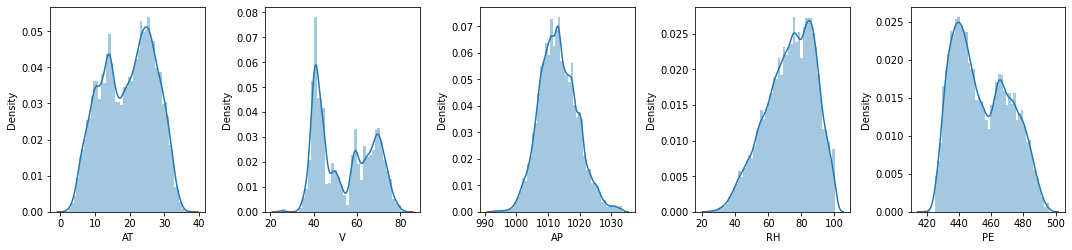

In [19]:
# distribution chart
plt.figure(figsize=(15,10))
n=0
for i in (lst_cont):
    n=n+1
    plt.subplot(3,5,n)
    sns.distplot(df[i])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

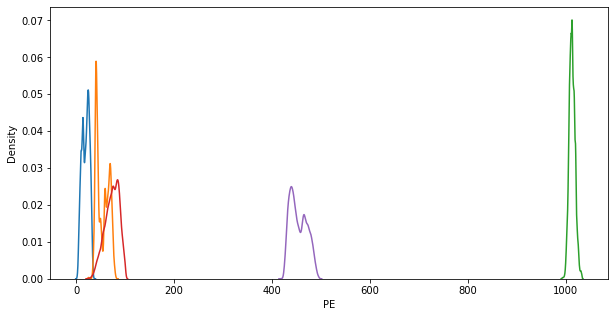

In [20]:
# distribution chart
f, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
for i in (lst_cont):
    sns.distplot(df[i], ax= ax1, hist=False)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

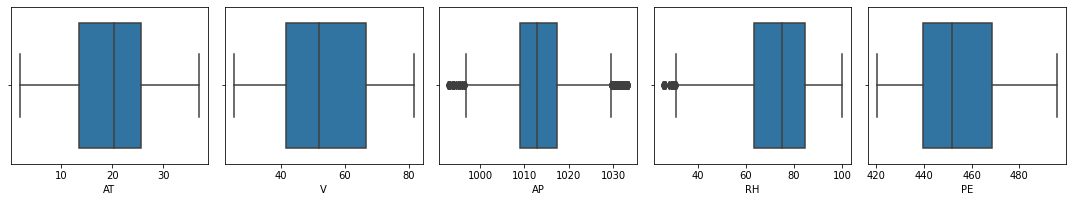

In [21]:
### boxplot
plt.figure(figsize=(15,8))
n=0
for i in (lst_cont):
    n=n+1
    plt.subplot(3,5,n)
    sns.boxplot(df[i])
plt.tight_layout()
plt.show()

* "AP" and "RH" have outliers, but these outlier can be accepted

#### Category variables

In [22]:
# lst_cate = ['Ship_name', 'Cruise_line']
# for i in lst_cate:
#   data.groupBy(i).count().show()

### Bi-variable Analysis

#### Continious & Continious

In [23]:
# correlation matrix
df[lst_cont].corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


* "PE" has high correlation with "AT" and "V", has week correlation with "AP" and "RH"

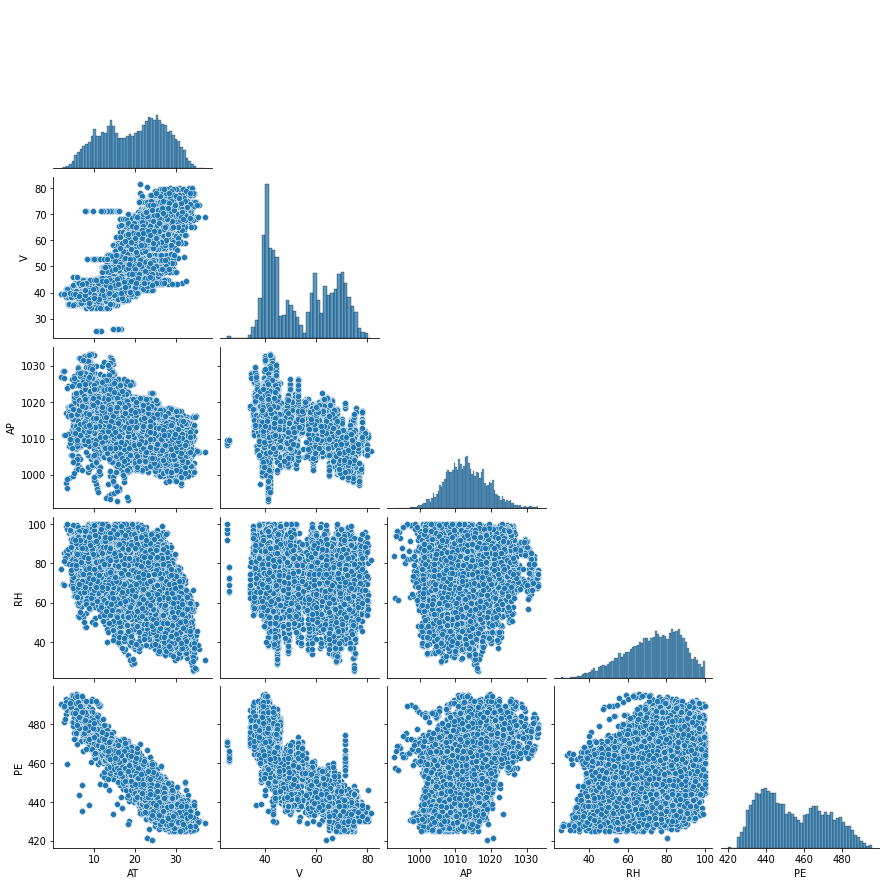

In [24]:
# correlation chart
sns.pairplot(df[lst_cont], corner = True)

- High correlation: [['AT', 'PE'], ['V', 'PE'], ['PE', 'PE']]


- Week correlation: [['AP', 'PE'], ['RH', 'PE']]


- Zero correlation: []


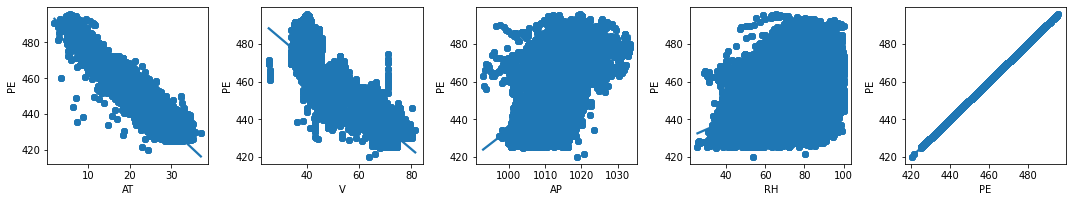

- Conclusion: Features have correlation with output variable PE : ['AP', 'AT', 'RH', 'V']


In [25]:
# correlation between output variable and input variables
j = 'PE'
pair1 = []
pair2 = []
pair3 = []

for i in lst_cont:
    corr = abs((df[[i,j]].corr().loc[[i],[j]]).values[0][0])
    if corr >= 0.6:
        pair1.append([i,j])
    elif corr >= 0.3:
        pair2.append([i,j])
    else: 
        pair3.append([i,j])
print('- High correlation:', pair1)
print('\n')
print('- Week correlation:', pair2)
print('\n')
print('- Zero correlation:', pair3)

### regression plot
n=0
plt.figure(figsize=(15,8))
for i in lst_cont:
    n = n+1
    plt.subplot(3,5,n)
    sns.regplot(data=df, x=i, y=j)
plt.tight_layout()
plt.show()
    
# lst_cont_chosen = list(set([item for sublist in (pair1 + pair2) for item in sublist]))
lst_cont_chosen = list(set([item for sublist in (pair1 + pair2) for item in sublist]))
lst_cont_chosen.remove(j)
print('- Conclusion: Features have correlation with output variable',j,':', lst_cont_chosen)

In [26]:
# correlation between inputs variable and input variables

pair1 = []
pair2 = []
pair3 = []
pair4 = []

for i in lst_cont:
    for j in lst_cont[lst_cont.index(i)+1:]:
        corr = abs((df[[i,j]].corr().loc[[i],[j]]).values[0][0])
        if corr >= 0.9:
            pair1.append([i,j])         
        elif corr >= 0.6:
            pair2.append([i,j])          
            
        elif corr >= 0.3:
            pair3.append([i,j])
        else: 
            pair4.append([i,j])

print('- High correlation (>0.9):', pair1)
print('\n')
print('- Medium correlation (<0.9):', pair2)
print('\n')
print('- Week correlation (<0.6):', pair3)
print('\n')
print('- Zerio correlation (<0.3):', pair4)

- High correlation (>0.9): [['AT', 'PE']]


- Medium correlation (<0.9): [['AT', 'V'], ['V', 'PE']]


- Week correlation (<0.6): [['AT', 'AP'], ['AT', 'RH'], ['V', 'AP'], ['V', 'RH'], ['AP', 'PE'], ['RH', 'PE']]


- Zerio correlation (<0.3): [['AP', 'RH']]


## Fearture engineering

In [27]:
# stringidx = StringIndexer(inputCol='Cruise_line',
#                               outputCol='Cruise_line_cate')

In [28]:
# stringidx = stringidx.fit(data)
# stringidxed = stringidx.transform(data)
# stringidxed.show(5)

## Vector Assembler

In [29]:
# Create an assembler
assembler = VectorAssembler(
                            inputCols=['AT', 'V', 'AP', 'RH'],
                            outputCol='features'
                            ) # inputs

In [30]:
# Transfom data by assembler
data_pre = assembler.transform(data)

In [31]:
# Data_pre after transfoming
data_pre.select('features').show(2,truncate=False)

+---------------------------+
|features                   |
+---------------------------+
|[14.96,41.76,1024.07,73.17]|
|[25.18,62.96,1020.04,59.08]|
+---------------------------+
only showing top 2 rows



In [32]:
# Just select features (after transforming from 4 columns) and output
final_data = data_pre.select('features','PE')

In [33]:
final_data.show(2,truncate=False)

+---------------------------+------+
|features                   |PE    |
+---------------------------+------+
|[14.96,41.76,1024.07,73.17]|463.26|
|[25.18,62.96,1020.04,59.08]|444.37|
+---------------------------+------+
only showing top 2 rows



## Train, Test split

In [34]:
# Train, Test split with ratio: 70:30
train_data, test_data = final_data.randomSplit([0.7,0.3])

In [35]:
train_data.describe().show()

+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|             33601|
|   mean|454.21632391893115|
| stddev|17.048005885630932|
|    min|            420.26|
|    max|            495.76|
+-------+------------------+



In [36]:
test_data.describe().show()

+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|             14239|
|   mean|454.71587541259714|
| stddev|17.104806922814703|
|    min|            420.26|
|    max|            495.35|
+-------+------------------+



=> Train data and test data description are the same. Do not have an significant difference

## Build model

In [37]:
# Create a Linear Regression Model object
lr = LinearRegression(featuresCol='features',
                      labelCol='PE',
                      predictionCol='prediction')

# Create a RandomForest Regression Model object
rf = RandomForestRegressor(featuresCol='features',
                        labelCol='PE',
                        predictionCol='prediction')

# Gradient-Boosted Tree Regression
gbt = GBTRegressor(featuresCol='features',
                    labelCol='PE',
                    predictionCol='prediction')
# => default: featuresCol='features', labelCol='label', predictionCol='prediction'

In [38]:
# Fit the model to the data and call this model lrModel
lrModel = lr.fit(train_data)
rfModel = rf.fit(train_data)
gbtModel = gbt.fit(train_data)

In [39]:
# Print the cofficients and intercept for linear regression
print('Coefficients : {} Intercept: {}'.format(lrModel.coefficients, lrModel.intercept))

Coefficients : [-1.9760403851847506,-0.23395657146053858,0.06193198155343762,-0.1597978225584173] Intercept: 454.86859394587725


## Model evaluation

In [40]:
test_results_lr = lrModel.evaluate(test_data)

In [41]:
# Interesting results...
test_results_lr.residuals.show(5)

+-------------------+
|          residuals|
+-------------------+
|-2.8189448962531856|
|-2.8189448962531856|
| -4.535188798308809|
| -4.535188798308809|
| -4.535188798308809|
+-------------------+
only showing top 5 rows



In [42]:
print('RMSE: {}'.format(test_results_lr.rootMeanSquaredError))
print('MSE: {}'.format(test_results_lr.meanSquaredError))
print('r2: {}'.format(test_results_lr.r2))

RMSE: 4.514459774167971
MSE: 20.38034705258073
r2: 0.9303364304129902


In [43]:
# make predictions on the testing data
predictions_lr = lrModel.transform(test_data)
predictions_rf = rfModel.transform(test_data)
predictions_gbt = gbtModel.transform(test_data)

In [44]:
eval_model = RegressionEvaluator(labelCol='PE', predictionCol='prediction')

In [45]:
# Linear Regression
eval_model.evaluate(predictions_lr, {eval_model.metricName:'r2'})

0.9303364304129902

In [46]:
eval_model.evaluate(predictions_lr, {eval_model.metricName:'rmse'})

4.514459774167971

In [47]:
# RandomForest Regression
eval_model.evaluate(predictions_rf, {eval_model.metricName:'r2'})

0.9378501920791672

In [48]:
eval_model.evaluate(predictions_rf, {eval_model.metricName:'rmse'})

4.264055227168579

In [49]:
# Gradient-Boosted Tree Regression
eval_model.evaluate(predictions_gbt, {eval_model.metricName:'r2'})

0.9493419344200764

In [50]:
eval_model.evaluate(predictions_gbt, {eval_model.metricName:'rmse'})

3.8497030089493003

In [51]:
data.select('PE').agg({'PE':'stddev'}).show()

+-----------------+
|       stddev(PE)|
+-----------------+
|17.06628146683769|
+-----------------+



* RMSE of lrModel = 4.54 << stddev of test_data  = 17,067 
* RMSE of rfModel = 4.24 << stddev of test_data  = 17,067 
* RMSE of gbtModel = 3.79 << stddev of test_data  = 17,067 
* R^2 of lrModel = 92.91%
* R^2 of rfModel = 93,84%
* R^2 of gbtModel = 95,06%
* gbtModel is the best model
* But both three models are very goood. So we can save both of them.


In [52]:
# check test dataset
test_model_lr = lrModel.transform(test_data)
test_model_rf = rfModel.transform(test_data)
test_model_gbt = gbtModel.transform(test_data)

In [53]:
# Inspect results
test_model_lr.select('prediction', 'PE').show(5)

+-----------------+------+
|       prediction|    PE|
+-----------------+------+
|493.3689448962532|490.55|
|493.3689448962532|490.55|
|493.2251887983088|488.69|
|493.2251887983088|488.69|
|493.2251887983088|488.69|
+-----------------+------+
only showing top 5 rows



In [54]:
# Inspect results
test_model_rf.select('prediction', 'PE').show(5)

+------------------+------+
|        prediction|    PE|
+------------------+------+
| 482.8314168514713|490.55|
| 482.8314168514713|490.55|
|482.98972274578017|488.69|
|482.98972274578017|488.69|
|482.98972274578017|488.69|
+------------------+------+
only showing top 5 rows



In [55]:
# Inspect results
test_model_gbt.select('prediction', 'PE').show(5)

+------------------+------+
|        prediction|    PE|
+------------------+------+
|487.11509878615016|490.55|
|487.11509878615016|490.55|
|486.82968049432736|488.69|
|486.82968049432736|488.69|
|486.82968049432736|488.69|
+------------------+------+
only showing top 5 rows



## Save and Load model

In [56]:
# Save model
lrModel.write().overwrite().save('C3_Regression_lr_Combined_Cycle_Power_Plant')
rfModel.write().overwrite().save('C3_Regression_rf_Combined_Cycle_Power_Plant')
gbtModel.write().overwrite().save('C3_Regression_gbt_Combined_Cycle_Power_Plant')

In [57]:
from pyspark.ml.regression import LinearRegressionModel, RandomForestRegressionModel

In [58]:
 # Load model
lrModel_2 = LinearRegressionModel.load('C3_Regression_lr_Combined_Cycle_Power_Plant')
rfModel_2 = RandomForestRegressionModel.load('C3_Regression_rf_Combined_Cycle_Power_Plant')
gbtModel_2 = GBTRegressionModel.load('C3_Regression_gbt_Combined_Cycle_Power_Plant')

## New data prediction

In [59]:
# Predict new values (assuming select test_data)
unlabeled_data = test_data.select('features')

In [60]:
predictions_lr = lrModel_2.transform(unlabeled_data)
predictions_rf = rfModel_2.transform(unlabeled_data)
predictions_gbt = gbtModel_2.transform(unlabeled_data)

In [61]:
predictions_lr.show(5)

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[1.81,39.42,1026....|493.3689448962532|
|[1.81,39.42,1026....|493.3689448962532|
|[2.58,39.42,1028....|493.2251887983088|
|[2.58,39.42,1028....|493.2251887983088|
|[2.58,39.42,1028....|493.2251887983088|
+--------------------+-----------------+
only showing top 5 rows



In [62]:
predictions_rf.show(5)

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[1.81,39.42,1026....| 482.8314168514713|
|[1.81,39.42,1026....| 482.8314168514713|
|[2.58,39.42,1028....|482.98972274578017|
|[2.58,39.42,1028....|482.98972274578017|
|[2.58,39.42,1028....|482.98972274578017|
+--------------------+------------------+
only showing top 5 rows



In [63]:
predictions_gbt.show(5)

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[1.81,39.42,1026....|487.11509878615016|
|[1.81,39.42,1026....|487.11509878615016|
|[2.58,39.42,1028....|486.82968049432736|
|[2.58,39.42,1028....|486.82968049432736|
|[2.58,39.42,1028....|486.82968049432736|
+--------------------+------------------+
only showing top 5 rows



## Pipeline

### create model

In [64]:
# Create an assembler
assembler = VectorAssembler(
                            inputCols=['AT', 'V', 'AP', 'RH'],
                            outputCol='features'
                            ) # inputs

# Scaler
scaler = StandardScaler(inputCol='features',
                        outputCol='scaledFeatures',
                        withStd=True,
                        withMean=False)

In [65]:
# Linear Regression Model
lr = LinearRegression(featuresCol='features',
                      labelCol='PE',
                      predictionCol='prediction')

# RandomForest Regression Model
rf = RandomForestRegressor(featuresCol='features',
                        labelCol='PE',
                        predictionCol='prediction')
# Gradient-Boosted Tree Regression
gbt = GBTRegressor(featuresCol='features',
                    labelCol='PE',
                    predictionCol='prediction')

# => default: featuresCol='features', labelCol='label', predictionCol='prediction'

In [66]:
# construct a pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

### train, test spliting

In [67]:
train_data2, test_data2 = data.randomSplit([0.7,0.3])

In [68]:
train_data2.count()

33668

In [69]:
test_data2.count()

14172

### fit pipeline mode

In [70]:
# train the pipeline on the training data
pipeline_model_lr = pipeline_lr.fit(train_data2)
pipeline_model_rf = pipeline_rf.fit(train_data2)
pipeline_model_gbt = pipeline_gbt.fit(train_data2)

In [71]:
# make predictions on the testing data
predictions_lr = pipeline_model_lr.transform(test_data2)
predictions_rf = pipeline_model_rf.transform(test_data2)
predictions_gbt = pipeline_model_gbt.transform(test_data2)

In [72]:
# inspect results
predictions_lr.show(5)

+----+-----+-------+-----+------+--------------------+--------------------+------------------+
|  AT|    V|     AP|   RH|    PE|            features|      scaledFeatures|        prediction|
+----+-----+-------+-----+------+--------------------+--------------------+------------------+
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028....|[0.34660599556877...| 493.2399267843636|
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028....|[0.34660599556877...| 493.2399267843636|
|2.71|39.42|1026.66|81.11| 489.3|[2.71,39.42,1026....|[0.36407063875635...|490.95025690787264|
|2.71|39.42|1026.66|81.11| 489.3|[2.71,39.42,1026....|[0.36407063875635...|490.95025690787264|
| 2.8|39.64|1011.01|82.96|482.66|[2.8,39.64,1011.0...|[0.37616154557851...| 489.4609016070633|
+----+-----+-------+-----+------+--------------------+--------------------+------------------+
only showing top 5 rows



In [73]:
predictions_rf.show(5)

+----+-----+-------+-----+------+--------------------+--------------------+------------------+
|  AT|    V|     AP|   RH|    PE|            features|      scaledFeatures|        prediction|
+----+-----+-------+-----+------+--------------------+--------------------+------------------+
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028....|[0.34660599556877...| 482.8651452945066|
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028....|[0.34660599556877...| 482.8651452945066|
|2.71|39.42|1026.66|81.11| 489.3|[2.71,39.42,1026....|[0.36407063875635...| 482.6422339971599|
|2.71|39.42|1026.66|81.11| 489.3|[2.71,39.42,1026....|[0.36407063875635...| 482.6422339971599|
| 2.8|39.64|1011.01|82.96|482.66|[2.8,39.64,1011.0...|[0.37616154557851...|482.70589086849975|
+----+-----+-------+-----+------+--------------------+--------------------+------------------+
only showing top 5 rows



In [74]:
predictions_gbt.show(5)

+----+-----+-------+-----+------+--------------------+--------------------+------------------+
|  AT|    V|     AP|   RH|    PE|            features|      scaledFeatures|        prediction|
+----+-----+-------+-----+------+--------------------+--------------------+------------------+
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028....|[0.34660599556877...|  486.462513701533|
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028....|[0.34660599556877...|  486.462513701533|
|2.71|39.42|1026.66|81.11| 489.3|[2.71,39.42,1026....|[0.36407063875635...|487.08766510980774|
|2.71|39.42|1026.66|81.11| 489.3|[2.71,39.42,1026....|[0.36407063875635...|487.08766510980774|
| 2.8|39.64|1011.01|82.96|482.66|[2.8,39.64,1011.0...|[0.37616154557851...| 485.7568283252849|
+----+-----+-------+-----+------+--------------------+--------------------+------------------+
only showing top 5 rows



### evaluation

In [75]:
# create evaluation model
eval_model = RegressionEvaluator(labelCol='PE', predictionCol='prediction')

In [76]:
# evaluate build model one by one
lst_predictions = [predictions_lr, predictions_rf, predictions_gbt]
lst_r2 = ['r2']
lst_rmse = ['rmse']
lst_mse = ['mse']
for i in lst_predictions:
  eval_model = RegressionEvaluator(labelCol='PE', predictionCol='prediction')
  r2 = eval_model.evaluate(i, {eval_model.metricName:'r2'})
  rmse = eval_model.evaluate(i, {eval_model.metricName:'rmse'})
  mse = eval_model.evaluate(i, {eval_model.metricName:'mse'})
  lst_r2.append(r2)
  lst_rmse.append(rmse)
  lst_mse.append(mse)

In [77]:
# create DataFrame contains evaluation metrics
col_names = ['Model name','Linear Regression','RandomForest Regression','Gradient-Boosted Tree Regression']
summary = [lst_r2, lst_rmse, lst_mse]
summary_df = spark.createDataFrame(summary, col_names)

In [78]:
summary_df.show()

+----------+------------------+-----------------------+--------------------------------+
|Model name| Linear Regression|RandomForest Regression|Gradient-Boosted Tree Regression|
+----------+------------------+-----------------------+--------------------------------+
|        r2|0.9288823907982424|     0.9378708832753542|              0.9489163679975763|
|      rmse| 4.549847098864076|      4.252612561113269|              3.8561073151325904|
|       mse|20.701108623041844|     18.084713594938354|              14.869563625819074|
+----------+------------------+-----------------------+--------------------------------+



In [79]:
data.select('PE').agg({'PE':'stddev'}).show()

+-----------------+
|       stddev(PE)|
+-----------------+
|17.06628146683769|
+-----------------+



* RMSE of lrModel = 4.53 << stddev of test_data  = 17,067 
* RMSE of rfModel = 4.25 << stddev of test_data  = 17,067 
* RMSE of gbtModel = 3.87 << stddev of test_data  = 17,067 
* R^2 of lrModel = 92.98%
* R^2 of rfModel = 93,81%
* R^2 of gbtModel = 94.86%
* pipeline_model_gbt is the best model
* But both thress models are very good. So we can save both of them for using.

## Cross validation with pipeline models

In [82]:
# evaluate build model one by one
eval_model = RegressionEvaluator(labelCol='PE', predictionCol='prediction')
col_names = ['Model name','Linear Regression','RandomForest Regression','Gradient-Boosted Tree Regression']
lst_pipelines = [pipeline_lr, pipeline_rf, pipeline_gbt]
lst_r2_means = ['r2']
lst_rmse_means = ['rmse']
lst_mse_means = ['mse']
k=1
for i in lst_pipelines:
  lst_r2_cv = []
  lst_rmse_cv = []
  lst_mse_cv = []
  for n in range(1,6):
    train_data2, test_data2 = data.randomSplit([0.7,0.3])
    pipeline_model = i.fit(train_data2)
    predictions = pipeline_model.transform(test_data2)

    r2 = eval_model.evaluate(predictions, {eval_model.metricName:'r2'})
    rmse = eval_model.evaluate(predictions, {eval_model.metricName:'rmse'})
    mse = eval_model.evaluate(predictions, {eval_model.metricName:'mse'})

    lst_r2_cv.append(r2)
    lst_rmse_cv.append(rmse)
    lst_mse_cv.append(mse)

  print(col_names[k])
  print('r2',lst_r2_cv)
  print('rmse',lst_rmse_cv)
  print('mse',lst_mse_cv)
  k+=1
  lst_r2_means.append(float(np.mean(lst_r2_cv)))
  lst_rmse_means.append(float(np.mean(lst_rmse_cv)))
  lst_mse_means.append(float(np.mean(lst_mse_cv)))  

Linear Regression
r2 [0.9283303368488918, 0.9274169066502895, 0.9277251137108007, 0.9274790874959956, 0.92761510937909]
rmse [4.571583851999863, 4.576607614673837, 4.571587093144368, 4.569654262855889, 4.575663018886392]
mse [20.89937891586591, 20.94533725869055, 20.899408550204175, 20.881740082036995, 20.93669206240453]
RandomForest Regression
r2 [0.9360775689739309, 0.9379129365208914, 0.9375057850730675, 0.9376454921989245, 0.9371926478925259]
rmse [4.320596379503208, 4.253421956307383, 4.256344232045657, 4.255185225926313, 4.248654924309293]
mse [18.667553074576226, 18.091598338397723, 18.116466221668333, 18.106601306941567, 18.051068665857606]
Gradient-Boosted Tree Regression
r2 [0.9484960283744863, 0.9479395339170157, 0.9490995615307013, 0.9484554481024215, 0.9470327402316921]
rmse [3.865613764349228, 3.8900413403671155, 3.8707550942568547, 3.8707886652488375, 3.934837754277045]
mse [14.94296977512621, 15.132421629765183, 14.982744999715392, 14.983004891018878, 15.482948152484019

In [83]:
# create DataFrame contains evaluation metrics
col_names = ['Model name','Linear Regression','RandomForest Regression','Gradient-Boosted Tree Regression']
summary_cv = [lst_r2_cv, lst_rmse_cv, lst_mse_cv]
summary_df_cv = spark.createDataFrame(summary_cv, col_names)

In [84]:
summary_df_cv.show()

+------------------+------------------+-----------------------+--------------------------------+------------------+
|        Model name| Linear Regression|RandomForest Regression|Gradient-Boosted Tree Regression|                _5|
+------------------+------------------+-----------------------+--------------------------------+------------------+
|0.9484960283744863|0.9479395339170157|     0.9490995615307013|              0.9484554481024215|0.9470327402316921|
| 3.865613764349228|3.8900413403671155|     3.8707550942568547|              3.8707886652488375| 3.934837754277045|
| 14.94296977512621|15.132421629765183|     14.982744999715392|              14.983004891018878|15.482948152484019|
+------------------+------------------+-----------------------+--------------------------------+------------------+



## Save pipeline models

In [85]:
# save pipeline model
pipeline_model_lr.write().overwrite().save('C3_Regression_pipeline_lr_Combined_Cycle_Power_Plant')
pipeline_model_rf.write().overwrite().save('C3_Regression_pipeline_rf_Combined_Cycle_Power_Plant')
pipeline_model_gbt.write().overwrite().save('C3_Regression_pipeline_gbt_Combined_Cycle_Power_Plant')

## Prediction with pipeline models

In [86]:
# load pipeline model
pipeline_model_lr2 = PipelineModel.load('C3_Regression_pipeline_lr_Combined_Cycle_Power_Plant')
pipeline_model_rf2 = PipelineModel.load('C3_Regression_pipeline_rf_Combined_Cycle_Power_Plant')
pipeline_model_gbt2 = PipelineModel.load('C3_Regression_pipeline_gbt_Combined_Cycle_Power_Plant')

In [87]:
# predict new values
unlabeled_data = test_data2

In [88]:
# make predictions on the new data
predictions_lr2 = pipeline_model_lr2.transform(unlabeled_data)
predictions_rf2 = pipeline_model_rf2.transform(unlabeled_data)
predictions_gbt2 = pipeline_model_gbt2.transform(unlabeled_data)

In [89]:
# inspect results
predictions_lr2.show(5, truncate=False)

+----+-----+-------+-----+------+--------------------------+----------------------------------------------------------------------------+------------------+
|AT  |V    |AP     |RH   |PE    |features                  |scaledFeatures                                                              |prediction        |
+----+-----+-------+-----+------+--------------------------+----------------------------------------------------------------------------+------------------+
|1.81|39.42|1026.92|76.97|490.55|[1.81,39.42,1026.92,76.97]|[0.24316157053468435,3.103830252689784,173.085360660498,5.271086123193127]  |493.39981088314585|
|1.81|39.42|1026.92|76.97|490.55|[1.81,39.42,1026.92,76.97]|[0.24316157053468435,3.103830252689784,173.085360660498,5.271086123193127]  |493.39981088314585|
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028.68,69.03]|[0.3466059955687766,3.103830252689784,173.3820052236212,4.727336300948702]  |493.2399267843636 |
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028.68,69.03

In [90]:
# inspect results
predictions_rf2.show(5, truncate=False)

+----+-----+-------+-----+------+--------------------------+----------------------------------------------------------------------------+------------------+
|AT  |V    |AP     |RH   |PE    |features                  |scaledFeatures                                                              |prediction        |
+----+-----+-------+-----+------+--------------------------+----------------------------------------------------------------------------+------------------+
|1.81|39.42|1026.92|76.97|490.55|[1.81,39.42,1026.92,76.97]|[0.24316157053468435,3.103830252689784,173.085360660498,5.271086123193127]  |482.6422339971599 |
|1.81|39.42|1026.92|76.97|490.55|[1.81,39.42,1026.92,76.97]|[0.24316157053468435,3.103830252689784,173.085360660498,5.271086123193127]  |482.6422339971599 |
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028.68,69.03]|[0.3466059955687766,3.103830252689784,173.3820052236212,4.727336300948702]  |482.8651452945066 |
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028.68,69.03

In [91]:
# inspect results
predictions_gbt2.show(5, truncate=False)

+----+-----+-------+-----+------+--------------------------+----------------------------------------------------------------------------+------------------+
|AT  |V    |AP     |RH   |PE    |features                  |scaledFeatures                                                              |prediction        |
+----+-----+-------+-----+------+--------------------------+----------------------------------------------------------------------------+------------------+
|1.81|39.42|1026.92|76.97|490.55|[1.81,39.42,1026.92,76.97]|[0.24316157053468435,3.103830252689784,173.085360660498,5.271086123193127]  |487.08766510980774|
|1.81|39.42|1026.92|76.97|490.55|[1.81,39.42,1026.92,76.97]|[0.24316157053468435,3.103830252689784,173.085360660498,5.271086123193127]  |487.08766510980774|
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028.68,69.03]|[0.3466059955687766,3.103830252689784,173.3820052236212,4.727336300948702]  |486.462513701533  |
|2.58|39.42|1028.68|69.03|488.69|[2.58,39.42,1028.68,69.03

In [92]:
end_time = time.time()

In [93]:
duration = (end_time - start_time)/60
duration = int(duration)

In [94]:
print('Total time for model training is about', duration, 'minutes')

Total time for model training is about 8 minutes
